Before getting started in earnest with `eprempy`, one simple task you can perform to make sure everything is installed is to print the version number.

In [1]:
import eprempy
print(f"Using version {eprempy.__version__} of eprempy {chr(0x1f60a)}")

Using version 0.1.4 of eprempy 😊


### Creating an observer

The examples below assume a working knowledge of [EPREM](https://github.com/myoung-space-science/eprem) &mdash; essentially, they assume that you have successfully run EPREM and have access to both the runtime configuration file and the output files.

Most `eprempy` applications will begin by creating one or more observers. EPREM stores output in the form of "stream observers", with each observer file representing a set of connected simulation nodes. An observer file name has the form `obsNNNNNN.nc` or `fluxNNNNNN.nc`, where `NNNNNN` is the zero-padded number of the EPREM node-stream, and the letters `obs` or `flux` indicate whether the corresponding data contains the full particle distribution or pre-computed flux.

To create an observer, the user must provide the observer ID, which is simply the EPREM stream number in the case of a stream observer. There are two additional attributes that are necessary for uniquely specifying an observer: the path to the directory containing the EPREM output and the path to the EPREM configuration file. When working within the directory containing EPREM output and the configuration file, the `eprem.Observer` class will automatically detect the appropriate observer file and will search for a configuration file with a name matching a known pattern. However, you may always specify the data directory via `source` and the name of the configuration file via `config`. Either path may be relative to the current directory and may contain the `~` alias; the `config` path may also be relative to the `source` path.

In [2]:
from eprempy import eprem

stream = eprem.stream(4, source='data/with-dist/')
stream

Observer(4)

Each observer knows the location of its data file, as well as the runtime configuration file used to create the data.

In [3]:
print(stream.dataset.source.name)
print(stream.config.source.name)

obs000004.nc
eprem.cfg


We can request the value of simulation runtime parameters by aliased keyword. For example, let's check the assumed mean free path at 1 au. There are three possible ways we can refer to this parameter: 'lambda0', 'lamo', or 'lam0'.

In [4]:
for key in ('lambda0', 'lamo', 'lam0'):
    print(f"{key} = {stream[key]!r}")

lambda0 = Variable([1.], unit='au')
lamo = Variable([1.], unit='au')
lam0 = Variable([1.], unit='au')


We can also request an array-like observable quantity by one of its aliases. 

In [5]:
for alias in ('Vr', 'vr', 'Ur', 'ur'):
    print(f"{alias} = {stream[alias]!r}")

Vr = Quantity(unit='m s^-1', dimensions={'time', 'shell'})
vr = Quantity(unit='m s^-1', dimensions={'time', 'shell'})
Ur = Quantity(unit='m s^-1', dimensions={'time', 'shell'})
ur = Quantity(unit='m s^-1', dimensions={'time', 'shell'})


As show above, each observable quantity knows its metric unit and array dimensions. Dimension names have the same meaning as in the raw EPREM output.

It is possible to change an observable quantity's unit by calling its `withunit` method:

In [6]:
print(stream['vr'].unit)
print(stream['vr'].withunit('au / day').unit)
print(stream['flux'].unit)
print(stream['flux'].withunit('1 / (cm^2 s sr MeV)').unit)

m s^-1
au d^-1
J^-1 s^-1 sr^-1 m^-2
MeV^-1 s^-1 sr^-1 cm^-2


An observable quantity supports subscription by standard index types or by "measurable" indices. An index is measurable if it contains one or more numeric values followed by a unit-like string.

This is best illustrated by a concrete example. Let's first pick a particular time in hours and radius in au

In [7]:
time = stream['time'].withunit('hour')
print(f"time:\n{time[27]}\n")
radius = stream['radius'].withunit('au')
print(f"radius:\n{radius[27, 57]}")

time:
[67.2],
unit='h',
dimensions={'time'}

radius:
[[1.27798576]],
unit='au',
dimensions={'time', 'shell'}


Next, we'll retrieve the observable quantity representing plasma density.

In [8]:
rho = stream['rho']
print(f"density at fixed time:\n{rho[27, 56:59]}\n")
print(f"density at fixed radius:\n{rho[26:29, 57]}\n")
print(f"density at fixed time and radius:\n{rho[27, 57]}")

density at fixed time:
[[20884873.80632916  5146864.60956498 21476487.84191666]],
unit='m^-3',
dimensions={'time', 'shell'}

density at fixed radius:
[[ 5521952.49424706]
 [ 5146864.60956498]
 [18721643.43447628]],
unit='m^-3',
dimensions={'time', 'shell'}

density at fixed time and radius:
[[5146864.60956498]],
unit='m^-3',
dimensions={'time', 'shell'}


Finally, we'll create a measured index with value equivalent to our chosen time point and one equivalent to our chosen radius point. When we use the measured indices to subscript the density, we get a value very close to the value of density subscripted with standard indices.

In [9]:
t0 = 67.2, 'hour'
r0 = 1.27798576, 'au'
print(f"density at (t0, r0):\n{rho[t0, r0]}\n")

density at (t0, r0):
[[5146864.35972748]],
unit='m^-3',
dimensions={'time', 'radius'}



Each observable quantity has a `plot` method.

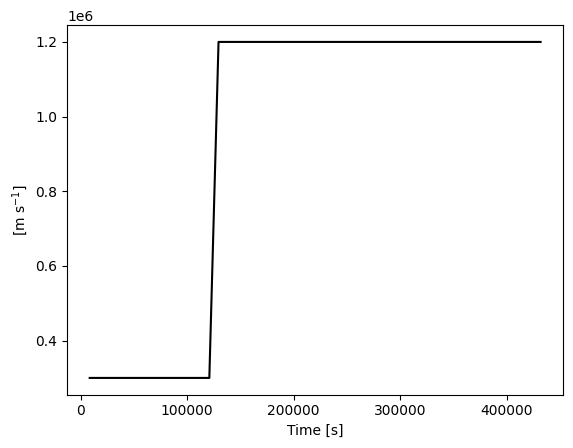

In [10]:
vr = stream['vr']
r0 = 0.5, 'au'
vr[:, r0].plot('k')

This method is useful for quickly viewing a single quantity. More complex plots require explicit use of a plotting module such as `matplotlib.pyplot`. The following example creates a slightly more complex version of the above plot, and demonstrates use of the `format` method for metric units.

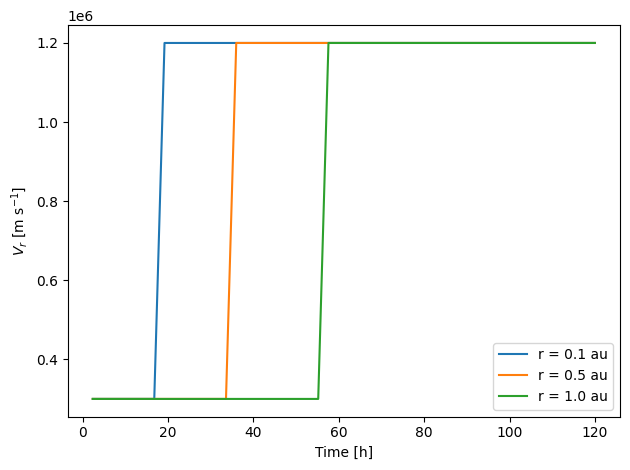

In [11]:
import matplotlib.pyplot as plt
for r in (0.1, 0.5, 1.0):
    plt.plot(time, vr[:, (r, 'au')], label=f"r = {r} au")
plt.legend()
plt.xlabel(f"Time [{time.unit}]")
plt.ylabel(rf"$V_r$ [{vr.unit.format(style='tex')}]")
plt.tight_layout()

You can print all observable quantities and parameters available to an observer by calling the observer's `which` method.

In [12]:
stream.which('observables')

'phiOffset'
't' == 'time' == 'times'
'shells' == 'shell'
'pitch-angle' == 'mu' == 'pitch angle' == 'pitch-angle cosine' == 'pitch angles' == 'pitch-angle cosines' == 'pitch-angles'
'mass' == 'm'
'charge' == 'q'
'energies' == 'E' == 'egrid' == 'energy'
'vgrid' == 'speed' == 'v'
'R' == 'radius' == 'r'
'theta' == 'T'
'P' == 'phi'
'br' == 'Br'
'bt' == 'Btheta' == 'btheta' == 'Bt'
'bp' == 'Bphi' == 'Bp' == 'bphi'
'ur' == 'Ur' == 'vr' == 'Vr'
'utheta' == 'Vtheta' == 'Vt' == 'ut' == 'Ut' == 'Utheta'
'Uphi' == 'Vp' == 'Vphi' == 'Up' == 'up' == 'uphi'
'rho' == 'Rho'
'f' == 'Dist' == 'dist'
'Flux' == 'j(E)' == 'J' == 'flux' == 'j' == 'J(E)'
'x' == 'X'
'y' == 'Y'
'z' == 'Z'
'|b|' == 'b mag' == 'B' == '|B|' == 'b' == 'b_mag' == 'bmag'
'|U|' == '|u|' == 'u mag' == 'umag' == 'u_mag' == 'U' == 'u'
'u_para' == 'Upara' == 'upara'
'uperp' == 'u_perp' == 'Uperp'
'flow angle' == 'flow_angle' == 'angle'
'divu' == 'div u' == 'divU' == 'div U' == 'div(u)' == 'div(U)' == 'div_u'
'Rg' == 'rigidity' == 'R_g'
'm

In [13]:
stream.which('parameters')

'minimum_energy' == 'minimum energy' == 'Emin'
'energy0' == 'reference energy'
'reference radius' == 'r0'
'FailModeDump'
'adiabaticChangeAlg'
'adiabaticFocusAlg'
'aziSunStart'
'J0' == 'boundaryFunctAmplitude'
'beta' == 'boundaryFunctBeta'
'boundaryFunctEcutoff' == 'E0'
'gamma' == 'boundaryFunctGamma'
'boundaryFunctXi' == 'xi'
'boundaryFunctionInitDomain'
'charge'
'checkSeedPopulation'
'dsh_hel_min'
'dsh_min'
'dumpFreq'
'dumpOnAbort'
'eMax'
'eMin'
'epCalcStartTime'
'epEquilibriumCalcDuration'
'epremDomain'
'epremDomainOutputTime'
'fieldAligned'
'flowMag'
'fluxLimiter'
'focusingLimit'
'gammaEhigh'
'gammaElow'
'idealShock'
'idealShockFalloff'
'idealShockInitTime'
'idealShockJump'
'idealShockPhi'
'idealShockScaleLength'
'idealShockSharpness'
'idealShockSpeed'
'idealShockTheta'
'idealShockWidth'
'idw_p'
'kper/kpar' == 'kperxkpar' == 'kper_kpar' == 'kper / kpar'
'lamo' == 'lam0' == 'lambda0'
'mass'
'mfp_radial_power' == 'mfpRadialPower'
'mhdBAu'
'mhdDensityAu'
'minInjectionEnergy'
'numColumn